In [1]:
import pandas as pd
from scipy.stats import norm
import csv
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import probscale
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
df = pd.read_csv(r'C:\Users\andrew.collord\Documents\PCRB\CESL Cross Qualification\Python Sameness\CESL Cross Qual Sameness Data.csv')

splits = pd.read_csv(r'C:\Users\andrew.collord\Documents\PCRB\CESL Cross Qualification\Python Sameness\SplitLotList.txt', sep=" ", header = None, names = ['Lot'])
# splits.Lot.apply(lambda x: x[:6])
splits = list(splits.Lot)

# Catagorize the data as Split or POR
df.loc[df.SOURCE_LOT.isin(splits), 'split'] = 'Split'
df.loc[~df.SOURCE_LOT.isin(splits), 'split'] = 'POR'
df['split'] = df['split'].astype('category')
df.split = df.split.cat.set_categories(['POR', 'Split'])


Import split lot data

In [4]:
# Catagorize The Data for Opens / Shorts / Bad
bad_values = [99995, 99996, 99997, 99999]

def bad_map(x):
    x = int(x)
    if x == 99995:
        return 'Bad'
    elif x == 99999:
        return 'Bad'
    elif x == 99996:
        return 'Short'
    elif x == 99997:
        return 'Open'
    
    return 'Good'


df['value_cat'] = df.SITE_VALUE.apply(bad_map)

# Filter parameters with less than 25% of data points (detail parameters)
count_pivot = df.pivot_table(values='SITE_VALUE', index=['PARAMETER'], aggfunc=[len] , margins=False)['len']
count_filter = count_pivot > count_pivot.quantile(0.75) *0.25
filtered_parameters = count_pivot[count_filter].index.tolist()

In [5]:
# Summary table of Bad data
bad_pivot = df.pivot_table(index=['PARAMETER', 'split'], columns='value_cat' , values='SITE_VALUE',  aggfunc='count', fill_value=0)
bad_pivot['Percent_Bad'] = bad_pivot.Bad/(bad_pivot.Bad + bad_pivot.Good) * 100
bad_pivot['Percent_Open'] = bad_pivot.Open/(bad_pivot.Open + bad_pivot.Good) * 100
bad_pivot['Percent_Short'] = bad_pivot.Short/(bad_pivot.Short + bad_pivot.Good) * 100

# Make the filter values categorical 
# This can't be done before making the pivot tables or you can't append the pivot table with the percent values
df['value_cat'] = df['value_cat'].astype('category')
df['value_cat'] = df['value_cat'].cat.set_categories(['Good', 'Bad', 'Short', 'Open'])

Add Data 6 IQR Data Filter

In [6]:
def pseudofilter(x):
    ''' Pseudo Sigma filter by spec
    
    parameter x: dataframe
    return dataframe with extra columns (low limit and high limit)
    '''
    
    filtered_value = x[x.value_cat == 'Good'].SITE_VALUE
    def doMath(value):
        six_iqr =  ((value.quantile(0.75) - value.quantile(0.25)) * 6 / 1.33)
        pseudo_high =  value.median() + six_iqr
        pseudo_low =  value.median() - six_iqr
        return pseudo_low, pseudo_high
    
    x['pseudo_low'], x['pseudo_high'] = doMath(filtered_value)
    return x

groups = df.groupby(['PARAMETER', 'split'])
df = groups.apply(pseudofilter)

Create the Filtered dataset and generate stats

In [7]:
# Filters values x where -6IQR < x < +6IQR and values are "Good"
f = (df.SITE_VALUE > df.pseudo_low) & (df.SITE_VALUE < df.pseudo_high) & (df.value_cat == 'Good')
df_filtered = df[f]

# Calculate the mean, stdev, and number of datapoints of the primary data
stats_pivot = df_filtered.pivot_table(values='SITE_VALUE',
                                      index=['PARAMETER', 'split'],
                                      aggfunc=[np.mean, np.std, len])

stats_pivot = stats_pivot.unstack(level = 1)

# Calculate the number of filtered values by parameter
filtered_pivot = df[~f].pivot_table(values='SITE_VALUE',
                                    index=['PARAMETER', 'split'],
                                    aggfunc=[len, ],
                                    fill_value=0)

filtered_pivot = filtered_pivot.rename(index=str, columns={'len': 'Filtered_Count'})
filtered_pivot = filtered_pivot.unstack(level=1)

#Join the filtered parameter stats table to the bulk dataset
combined_stats = filtered_pivot.join(stats_pivot)
combined_stats.columns = combined_stats.columns.droplevel(level = 1)

In [8]:
# Calculate the % difference in filtered data between split and POR, append as a new column
fc = combined_stats['Filtered_Count']
fc1 = (fc['Split'] - fc['POR']) * 1.0 / fc['POR']
combined_stats.loc[:, ('Filtered_Count', 'diff')] = fc1

stats_pivot.columns = stats_pivot.columns.droplevel(level = 1)

Sameness Analysis

In [9]:
def sameness(x):
    por_mean = x.loc[('mean', 'POR')]
    por_std = x.loc[('std', 'POR')]
    split_mean = x.loc[('mean', 'Split')]
    split_std = x.loc[('std', 'Split')]
    
    
    lower_3sigma = por_mean - (3 * por_std)
    upper_3sigma = por_mean + (3 * por_std)
    
    norm_split = norm(split_mean, split_std)
    
    lower_cdf = norm_split.cdf(lower_3sigma)
    upper_cdf = norm_split.cdf(upper_3sigma)
    
    sameness = (upper_cdf - lower_cdf) / 0.997
    
    return sameness

combined_stats['Sameness'] = stats_pivot.apply(sameness, axis=1)

C:\Users\andrew.collord\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1729: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\andrew.collord\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\andrew.collord\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\andrew.collord\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1730: RuntimeWarning: invalid value encountered in greater
  cond1 = self._open_support_mask(x) & (scale > 0)
C:\Users\andrew.collord\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1731: RuntimeWarning: invalid val

In [10]:
# Filter for split lots that have failed sameness
combined_pivot = combined_stats.join(bad_pivot.unstack(level=1))
sameness_filter = combined_pivot.Sameness < 0.95
sameness_filter = sameness_filter.rename('FailSameness')

# Filter for split lots that failed for filtered data - add column that indicates 
split_fails_filter = ((combined_pivot['Filtered_Count', 'Split'] > 1) & (combined_pivot['Filtered_Count', 'POR'] == 0)) | (combined_pivot['Filtered_Count', 'diff'] > 1)
split_fails_filter = split_fails_filter.rename('FailFilter')

# Merge sameness and failed filter indicators to df with all parameters
df = df.merge(sameness_filter.reset_index(), on='PARAMETER')
df = df.merge(split_fails_filter.reset_index(), on='PARAMETER')

In [32]:
# Append the fail filter and sameness data to the stats table
cs = combined_stats.reset_index().merge(sameness_filter.reset_index(), on='PARAMETER')
cs = cs.merge(split_fails_filter.reset_index(), on='PARAMETER')
cs[ ('Filtered_Count', 'diff')].fillna(0, inplace = True)

C:\Users\andrew.collord\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:543: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [31]:
cs

,PARAMETER,"(PARAMETER, )","(Filtered_Count, POR)","(Filtered_Count, Split)","(mean, POR)","(mean, Split)","(std, POR)","(std, Split)","(len, POR)","(len, Split)","(Filtered_Count, diff)","(Sameness, )",FailSameness,FailFilter
0,2PhiN2V_10,2PhiN2V_10,3.0,NaN,0.913323,0.913544,0.000899,0.001057,6067.0,250.0,0.000000,0.990528,False,False
1,2PhiN5V_10,2PhiN5V_10,3.0,1.0,0.835329,0.835113,0.001214,0.000941,6221.0,1233.0,-0.666667,1.002851,False,False
2,2PhiP2V_0.18,2PhiP2V_0.18,5.0,NaN,-0.940459,-0.940714,0.001482,0.000522,255.0,10.0,0.000000,1.003009,False,False
3,2PhiP2V_10,2PhiP2V_10,4.0,NaN,-0.935281,-0.935532,0.000848,0.001108,6066.0,250.0,0.000000,0.977867,False,False
4,2PhiP5VLN-AC_1.4,2PhiP5VLN-AC_1.4,1.0,NaN,-0.662232,-0.663556,0.002052,0.001797,259.0,10.0,0.000000,0.999396,False,False
5,2PhiP5VLN-AC_10,2PhiP5VLN-AC_10,1.0,NaN,-0.683334,-0.682854,0.001722,0.002087,264.0,15.0,0.000000,0.987160,False,False
6,2PhiP5V_0.4,2PhiP5V_0.4,10.0,NaN,-0.841508,-0.838599,0.001856,0.006237,255.0,15.0,0.000000,0.579847,True,False
7,2PhiP5V_0.8x0.4,2PhiP5V_0.8x0.4,10.0,NaN,-0.838346,-0.836101,0.001998,0.005719,255.0,15.0,0.000000,0.671086,True,False
8,2PhiP5V_1,2PhiP5V_1,4.0,NaN,-0.859860,-0.858890,0.001267,0.002401,261.0,15.0,0.000000,0.859850,True,False
9,2PhiP5V_10,2PhiP5V_10,14.0,NaN,-0.860628,-0.858914,0.001156,0.001630,6176.0,1234.0,0.000000,0.860770,True,False


In [35]:
cs.columns

Index([                'PARAMETER',           ('PARAMETER', ''),
         ('Filtered_Count', 'POR'), ('Filtered_Count', 'Split'),
                   ('mean', 'POR'),           ('mean', 'Split'),
                    ('std', 'POR'),            ('std', 'Split'),
                    ('len', 'POR'),            ('len', 'Split'),
        ('Filtered_Count', 'diff'),            ('Sameness', ''),
                    'FailSameness',                'FailFilter'],
      dtype='object')

In [12]:
#plot_data = df[(df.PARAMETER == 'VIA_TV1R_Cx112_Res') & (df.FailFilter == True) & (df.value_cat == 'Good')]
plot_data = df[(df.FailSameness == True) & (df.value_cat == 'Good')]
g = plot_data.groupby('PARAMETER')

In [77]:
def prob_plot(param, data):
    
    cols =  [('PARAMETER', ''), ('Filtered_Count', 'diff'), ('Sameness', ''), 'FailSameness', 'FailFilter']
    statable = cs[cs.PARAMETER == parameter][cols]
    statable.columns = ['Parameter', '%diff Filtered', 'Sameness', 'Fail Sameness?', 'Fail Filter?']
    statable = statable.round(decimals = 3)
    
    fg = (sns.FacetGrid(data=data, hue='split', size=8, aspect=1.25, table = statable) 
        .map(probscale.probplot, 'SITE_VALUE', probax='y')
        .set_ylabels('Normal Probability')
        .add_legend()
         )

    fg.set(xlabel = 'Site Value',  
            ylabel = 'Normalized Probability', 
            title = param)
    fg.ax.set_ylim(bottom=0.05, top=99.95)
    
       
    
#     plt.table(cellText=statable,
#           rowLabels=param.index,
#           colLabels=param.columns,
#           cellLoc = 'right', rowLoc = 'center',
#           loc='right', bbox=[.65,.05,.3,.5])

    return fg

In [78]:
testlist = list(plot_data.PARAMETER.unique()[:5])
testees = plot_data.loc[plot_data.PARAMETER.isin(testlist)]
pairoftestees = testees.groupby('PARAMETER')

In [79]:
for parameter, data in pairoftestees:
    prob_plot(parameter,data)

TypeError: __init__() got an unexpected keyword argument 'table'

In [16]:
with PdfPages('testplots.pdf') as pdf:

    for parameter, data in pairoftestees:
        prob_plot(parameter,data)
        
        pdf.savefig()
        plt.close()






C:\Users\andrew.collord\AppData\Local\Continuum\Anaconda3\lib\site-packages\probscale\probscale.py:44: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(z) * numpy.sqrt(numpy.sqrt(_b**2 - _c) - _b)
C:\Users\andrew.collord\AppData\Local\Continuum\Anaconda3\lib\site-packages\probscale\probscale.py:32: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(x) * numpy.sqrt(1.0 - numpy.exp(guts))


In [75]:
for parameter, data in pairoftestees:
    cols =  [('PARAMETER', ''), ('Filtered_Count', 'diff'), ('Sameness', ''), 'FailSameness', 'FailFilter']
    xx = cs[cs.PARAMETER == parameter][cols]
    xx.columns = ['Parameter', '%diff Filtered', 'Sameness', 'Fail Sameness?', 'Fail Filter?']
    xx = xx.round(decimals = 3)
    
    
    print(xx)
#     for parameter, data in pairoftestees:
#         prob_plot(parameter,data)
    
    
#     print(xx)

               Parameter  %diff Filtered  Sameness  Fail Sameness?  \
109  C_MIM25_12p5K_Tox_P             0.0     0.902            True   

     Fail Filter?  
109         False  
       Parameter  %diff Filtered  Sameness  Fail Sameness?  Fail Filter?
439  IN1_Hfe_1uA             0.0     0.635            True         False
        Parameter  %diff Filtered  Sameness  Fail Sameness?  Fail Filter?
541  IdonP5VNNW_1             0.0     0.892            True         False
         Parameter  %diff Filtered  Sameness  Fail Sameness?  Fail Filter?
649  LP1_BVcso_1uA          -0.667     0.894            True         False
                Parameter  %diff Filtered  Sameness  Fail Sameness?  \
1140  P_PE5VNW_10x1_Gnlin             0.0     0.901            True   

      Fail Filter?  
1140         False  


In [514]:
def prob_plot(param, data):
    fg = (sns.FacetGrid(data=data, hue='split', size=8, aspect=1.25) 
        .map(probscale.probplot, 'SITE_VALUE', probax='y')
        .set_ylabels('Normal Probability')
        .add_legend()
         )

    fg.set(xlabel = 'Site Value',  
            ylabel = 'Normalized Probability', 
            title = param)
    fg.ax.set_ylim(bottom=0.05, top=99.95)
    
    plt.table(cellText=data.Sameness,
          rowLabels=summary.index,x
          colLabels=summary.columns,
          cellLoc = 'right', rowLoc = 'center',
          loc='right', bbox=[.65,.05,.3,.5])
    
    return fg

# for parameter, data in g:
#     prob_plot(parameter,data)


C:\Users\andrew.collord\AppData\Local\Continuum\Anaconda3\lib\site-packages\probscale\probscale.py:44: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(z) * numpy.sqrt(numpy.sqrt(_b**2 - _c) - _b)
C:\Users\andrew.collord\AppData\Local\Continuum\Anaconda3\lib\site-packages\probscale\probscale.py:32: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(x) * numpy.sqrt(1.0 - numpy.exp(guts))


(0.05, 99.95)

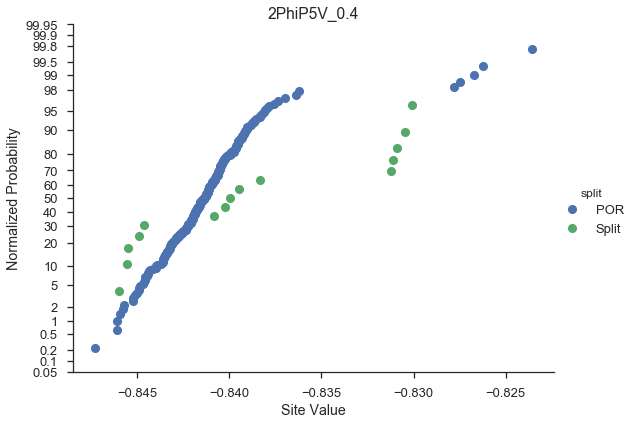

In [493]:
# This one works

param = '2PhiP5V_0.4'
data = plot_data.loc[plot_data.PARAMETER ==param]


fg = (sns.FacetGrid(data=data, hue='split', size=6, aspect=1.25) 
    .map(probscale.probplot, 'SITE_VALUE', probax='y')
    .set_ylabels('Normal Probability')
    .add_legend()
     )

fg.set(xlabel = 'Site Value',  
        ylabel = 'Normalized Probability', 
        title = param)
fg.ax.set_ylim(bottom=0.05, top=99.95)

    

In [492]:
df.head()
    

,LOT,WAFER,SITE,SPEC_FILE,PARAMETER,TEMPERATURE,MEASURE_TIME,PRODUCT,SOURCE_LOT,UNIT,SITE_VALUE,split,value_cat,pseudo_low,pseudo_high,FailSameness,FailFilter
0,JBHO03571,25,1,PROD^SL33P,PT_Rev_na_IOS_major,25,2017/02/02 11:39:39,CL54B-0C,J44233,x,500031.0,POR,Good,500031.0,500031.0,False,False
1,JBHO03571,25,2,PROD^SL33P,PT_Rev_na_IOS_major,25,2017/02/02 11:39:39,CL54B-0C,J44233,x,500031.0,POR,Good,500031.0,500031.0,False,False
2,JBHO03571,25,3,PROD^SL33P,PT_Rev_na_IOS_major,25,2017/02/02 11:39:39,CL54B-0C,J44233,x,500031.0,POR,Good,500031.0,500031.0,False,False
3,JBHO03571,25,4,PROD^SL33P,PT_Rev_na_IOS_major,25,2017/02/02 11:39:39,CL54B-0C,J44233,x,500031.0,POR,Good,500031.0,500031.0,False,False
4,JBHO03571,25,5,PROD^SL33P,PT_Rev_na_IOS_major,25,2017/02/02 11:39:39,CL54B-0C,J44233,x,500031.0,POR,Good,500031.0,500031.0,False,False


#Converted to markdown to supress
plot_data = df[(df.FailFilter == True )& (df.value_cat == 'Good']
g = plot_data.groupby('PARAMETER')
#Plot Tail Fails
for param, data in g:
    means = combined_stats.loc[param, 'mean']
    stds = combined_stats.loc[param, 'std']
    title = '{0} \n'.format(param)
    title = title + 'POR: Mean = {0:.3f}, Std= {1:.4f} \n'.format(means['POR'], stds['POR']
    title = title + 'Mean = {0:.3f}, Std= {1:.4f}'.format(means['Split'], stds['Split'])
                                                                  
    filename = 'out\{0}_fail_filtered_prob.png'.format(param)
    prob_plot(param, data, title, filename)

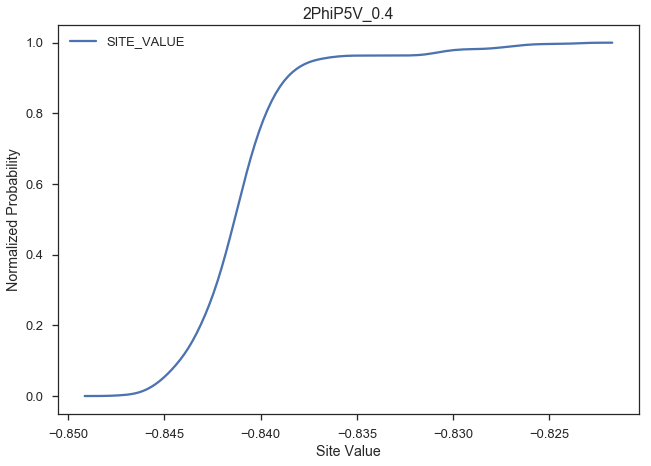

In [480]:
# fig, ax = plt.figure(figsize = (10,4))
# ax2 = fig.add_subplot

param = '2PhiP5V_0.4'
data = plot_data.loc[plot_data.PARAMETER ==param]
# splitdata = data.loc[data.split == ' Split']
# pordata = data.loc[data.split == 'POR']

fig = sns.kdeplot(data.SITE_VALUE, cumulative = True)

fig.set(xlabel = 'Site Value',  
        ylabel = 'Normalized Probability', 
        title = param)
# fig.axvline( x = )


In [474]:
tp

,LOT,WAFER,SITE,SPEC_FILE,PARAMETER,TEMPERATURE,MEASURE_TIME,PRODUCT,SOURCE_LOT,UNIT,SITE_VALUE,split,value_cat,pseudo_low,pseudo_high,FailSameness,FailFilter
4161248,JBVS23081,8,1,PROD^SL42B,2PhiP5V_0.4,25,2017/03/14 03:25:39,CL63B-0A,J44956,V,-0.826248,POR,Good,-0.851502,-0.831204,True,False
4161249,JBVS23081,8,2,PROD^SL42B,2PhiP5V_0.4,25,2017/03/14 03:25:39,CL63B-0A,J44956,V,-0.823583,POR,Good,-0.851502,-0.831204,True,False
4161250,JBVS23081,8,3,PROD^SL42B,2PhiP5V_0.4,25,2017/03/14 03:25:39,CL63B-0A,J44956,V,-0.826701,POR,Good,-0.851502,-0.831204,True,False
4161251,JBVS23081,8,4,PROD^SL42B,2PhiP5V_0.4,25,2017/03/14 03:25:39,CL63B-0A,J44956,V,-0.827824,POR,Good,-0.851502,-0.831204,True,False
4161252,JBVS23081,8,5,PROD^SL42B,2PhiP5V_0.4,25,2017/03/14 03:25:39,CL63B-0A,J44956,V,-0.827473,POR,Good,-0.851502,-0.831204,True,False
4161253,JBVS23087,5,1,PROD^SL42B,2PhiP5V_0.4,25,2017/03/11 00:42:04,CL63B-0A,J44984,V,-0.830069,Split,Good,-0.901262,-0.778620,True,False
4161254,JBVS23087,5,2,PROD^SL42B,2PhiP5V_0.4,25,2017/03/11 00:42:04,CL63B-0A,J44984,V,-0.830445,Split,Good,-0.901262,-0.778620,True,False
4161255,JBVS23087,5,3,PROD^SL42B,2PhiP5V_0.4,25,2017/03/11 00:42:04,CL63B-0A,J44984,V,-0.831087,Split,Good,-0.901262,-0.778620,True,False
4161256,JBVS23087,5,4,PROD^SL42B,2PhiP5V_0.4,25,2017/03/11 00:42:04,CL63B-0A,J44984,V,-0.830924,Split,Good,-0.901262,-0.778620,True,False
4161257,JBVS23087,5,5,PROD^SL42B,2PhiP5V_0.4,25,2017/03/11 00:42:04,CL63B-0A,J44984,V,-0.831234,Split,Good,-0.901262,-0.778620,True,False


In [425]:
cs = combined_stats.reset_index().merge(sameness_filter.reset_index(), on='PARAMETER')
cs = cs.merge(split_fails_filter.reset_index(), on='PARAMETER')

C:\Users\andrew.collord\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:543: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


## Data summary output is here
 Recomend to feed the failed parameters into ACE to generate the plots

In [426]:
cs.head()
# cs.to_csv('Parameter_Summary.csv')

,PARAMETER,"(PARAMETER, )","(Filtered_Count, POR)","(Filtered_Count, Split)","(mean, POR)","(mean, Split)","(std, POR)","(std, Split)","(len, POR)","(len, Split)","(Filtered_Count, diff)","(Sameness, )",FailSameness,FailFilter
0,2PhiN2V_10,2PhiN2V_10,3.0,NaN,0.913323,0.913544,0.000899,0.001057,6067.0,250.0,NaN,0.990528,False,False
1,2PhiN5V_10,2PhiN5V_10,3.0,1.0,0.835329,0.835113,0.001214,0.000941,6221.0,1233.0,-0.666667,1.002851,False,False
2,2PhiP2V_0.18,2PhiP2V_0.18,5.0,NaN,-0.940459,-0.940714,0.001482,0.000522,255.0,10.0,NaN,1.003009,False,False
3,2PhiP2V_10,2PhiP2V_10,4.0,NaN,-0.935281,-0.935532,0.000848,0.001108,6066.0,250.0,NaN,0.977867,False,False
4,2PhiP5VLN-AC_1.4,2PhiP5VLN-AC_1.4,1.0,NaN,-0.662232,-0.663556,0.002052,0.001797,259.0,10.0,NaN,0.999396,False,False
